In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
df=pd.read_csv('Classification_train.csv')
df=df.sample(frac=1).reset_index(drop=True)

In [63]:
df.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      5       0       0       0       0       0       0       0       0   
1      6       0       0       0       0       0       0       0       0   
2      7       0       0       0       0       0       0       0       0   
3      1       0       0       0       0       0       0       0       0   
4      8       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [64]:
X_train=np.array(df.loc[0:23999, 'pixel0' : 'pixel783']).T/255
y_train=np.array(df.loc[0:23999, 'label']).reshape(1,X_train.shape[1])
print(X_train.shape)
print(y_train.shape)

(784, 24000)
(1, 24000)


In [65]:
X_cv=np.array(df.loc[24000:, 'pixel0' : 'pixel783']).T/255
y_cv=np.array(df.loc[24000:, 'label']).reshape(1,X_cv.shape[1])
print(X_cv.shape)
print(y_cv.shape)

(784, 6000)
(1, 6000)


In [66]:
def onehot(y):
    u=np.unique(y)
    return (u.reshape((-1,1))==y.reshape((1,-1)))*1

In [67]:
y_train_a=onehot(y_train)

In [68]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis = 0)

def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return (x>0)*1

In [69]:
def initialise_parameters(neurons_of_layer):
    L=len(neurons_of_layer)
    parameters={}
    for i in range (1,L):
        parameters["W"+str(i)]=np.random.randn(neurons_of_layer[i],neurons_of_layer[i-1])*np.sqrt(2/neurons_of_layer[i])
        parameters["b"+str(i)]=np.zeros((neurons_of_layer[i],1))
    return parameters

In [70]:
def forward_prop(X,parameters,active='relu'):
    forward={}
    L=len(parameters)//2
    forward["A0"]=X
    for i in range(1,L):
        forward["Z"+str(i)]=np.dot(parameters["W"+str(i)],forward["A"+str(i-1)])+parameters["b"+str(i)]
        if active=='relu':
            forward["A"+str(i)]=relu(forward["Z"+str(i)])
        else:
            forward["A"+str(i)]=tanh(forward["Z"+str(i)])
    forward["Z"+str(L)]=np.dot(parameters["W"+str(L)],forward["A"+str(L-1)])+parameters["b"+str(L)]
    forward["A"+str(L)]=softmax(forward["Z"+str(L)])
    return forward["A"+str(L)],forward

In [71]:
def compute_cost(A_L,Y):
    m=Y.shape[1]
    cost=(-1/m)*np.sum(Y*np.log(A_L))
    cost=np.squeeze(cost)
    return cost

In [72]:
def back_prop(AL, Y, parameters, forward, activation):
    gradients = {}
    L = len(parameters)//2
    m = AL.shape[1]
    gradients["dZ"+str(L)]=AL - Y
    gradients["dW"+str(L)]=1./m*np.dot(gradients["dZ"+str(L)],forward['A'+str(L-1)].T)
    gradients["db"+str(L)]=1./m*np.sum(gradients["dZ"+str(L)],axis = 1,keepdims=True)
    for l in reversed(range(1, L)):
        if activation == 'tanh':
            gradients["dZ"+str(l)]=np.dot(parameters["W"+str(l+1)].T,gradients["dZ"+str(l+1)])*derivative_tanh(forward['A'+str(l)])
        else:
            gradients["dZ"+str(l)]=np.dot(parameters["W"+str(l+1)].T,gradients["dZ"+str(l+1)])*derivative_relu(forward['A'+str(l)])
        gradients["dW"+str(l)]=1./m*np.dot(gradients["dZ"+str(l)],forward["A"+str(l-1)].T)
        gradients["db"+str(l)]=1./m*np.sum(gradients["dZ"+str(l)],axis=1,keepdims=True)
    return gradients

In [73]:
def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-learning_rate*gradients["dW"+str(l+1)]
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-learning_rate*gradients["db"+str(l+1)]
    return parameters

In [74]:
def predict(X,y,parameters,activation):
    m = X.shape[1]
    y_pred,forward=forward_prop(X,parameters,activation)
    y_pred=np.argmax(y_pred,0)
    
    return np.sum((y_pred==y))/m

In [93]:
def model(X,y,neurons_of_layer,learning_rate,epochs,batch_size,activation='relu'):
    np.random.seed(420)
    parameters=initialise_parameters(neurons_of_layer)
    cost=[]
    A_L,forward=forward_prop(X,parameters,activation)
    ct=compute_cost(A_L,y)
    print("Cost at epoch ",0," = ",ct)
    cost.append(ct)
    for ep in range (epochs):
        it=X.shape[1]//batch_size
        for i in range(it):
            x_mini=X[:,batch_size*i:batch_size*(i+1)]
            y_mini=y[:,batch_size*i:batch_size*(i+1)]
            A_L,forward=forward_prop(x_mini,parameters,activation)
            gradients=back_prop(A_L,y_mini,parameters,forward,activation)
            parameters=update_parameters(parameters,gradients,learning_rate)
        A_L,forward=forward_prop(X,parameters,activation)
        ct=compute_cost(A_L,y)
        print("Cost at epoch ",ep+1," = ",ct)
        cost.append(ct)
    return parameters,cost

In [111]:
neurons_of_layer=[X_train.shape[0],512,256,128,10]
lr=0.1
epochs=30
parameters,cost=model(X_train,y_train_a,neurons_of_layer,lr,epochs,64,'relu')


Cost at epoch  0  =  5.480157370234495
Cost at epoch  1  =  0.055877375791666094
Cost at epoch  2  =  0.02220219257399788
Cost at epoch  3  =  0.012324826157810217
Cost at epoch  4  =  0.013484918841274547
Cost at epoch  5  =  0.0065195980350396384
Cost at epoch  6  =  0.0029751011487370383
Cost at epoch  7  =  0.002126844753661057
Cost at epoch  8  =  0.001633405142362008
Cost at epoch  9  =  0.0013415104081801704
Cost at epoch  10  =  0.0011304335993942195
Cost at epoch  11  =  0.0009741663377246453
Cost at epoch  12  =  0.0008550921691673429
Cost at epoch  13  =  0.0007650910306579123
Cost at epoch  14  =  0.0006889104124673643
Cost at epoch  15  =  0.000627598516005073
Cost at epoch  16  =  0.0005750417350109422
Cost at epoch  17  =  0.0005312528247954359
Cost at epoch  18  =  0.0004930064880856891
Cost at epoch  19  =  0.0004593863355467176
Cost at epoch  20  =  0.00043058723696704464
Cost at epoch  21  =  0.0004047932671243952
Cost at epoch  22  =  0.000381737541946734
Cost at ep

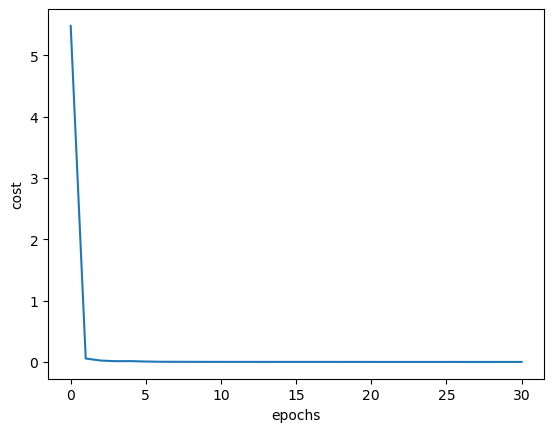

In [112]:
plt.plot(cost)
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

In [117]:
acc=predict(X_train,y_train,parameters,'relu')
print(acc)

1.0


In [116]:
acc_cv=predict(X_cv,y_cv,parameters,'relu')
print(acc_cv)

0.985


In [118]:
df2=pd.read_csv("Classification_test.csv")
df2.head()

ID  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0  15795       0       0       0       0       0       0       0       0   
1    860       0       0       0       0       0       0       0       0   
2   5390       0       0       0       0       0       0       0       0   
3  11964       0       0       0       0       0       0       0       0   
4  11284       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [120]:
X_test=np.array(df2.loc[:,"pixel0":"pixel783"])